# Convert Streamed Twitter API JSON file to NetworkX & Gephi

Developed by Chris Allison - @ToferC

This notebook takes a custom JSON dict of tweets pulled from the Twitter API, extracts the key data desired and creates first a NetworkX Graph and then exports to a Gephi file.

Tweets are collected by twitter_to_json.py and placed in the results directory with the title "search_"query_name".json


In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import tweepy
import os
import datetime, time
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
import json

%matplotlib inline

In [2]:
# Set up source and data directories - configure these as required

home_dir = "/Users/christopherallison/.virtualenvs/py_twi/streaming_results"
save_dir = "/Users/christopherallison/Documents/Coding/Gephi/twitter_stream"

In [3]:
# Enter your search queries here separated by spaces - 
# You must have already run search_twitter_to_json.py for the query

search_queries = "trudeau".split()

### Processing functions

The following functions are used by the main script to prep data

In [4]:
def find_user(tweet_id, tweet_dict):
    # Find tweet author based on tweet status ID
    try:
        x = tweet_dict[tweet_id]['user_screen_name']
    except KeyError:
        x = None # User is out of scope
    return x

In [5]:
first_cap_re = re.compile('(.)([A-Z][a-z]+)')
all_cap_re = re.compile('([a-z0-9])([A-Z])')

def convert(name):
    # Convert text to camel_case
    s1 = first_cap_re.sub(r'\1_\2', name)
    return all_cap_re.sub(r'\1_\2', s1).lower()

# Full function for network graphing

In [6]:
def twitter_data_to_graph(search_query):
    # Convert JSON file of tweets to NetworkX Graph and Gephi graph file
    
    # Set up empty strings for NTLK analysis
    full_tweets = ""
    full_hashtags = ""
    
    # Create dict for storing user data
    users = {}
    
    for sq in search_query:
        
        tweets = {}
        
        # Open source files for each query
        
        with open(os.path.join(home_dir, '{}_stream.json'.format(sq)), 'r') as f:
        
            for data in f:
        
                result = json.loads(data)

                try:
                    id_str = result['id_str']

                    tweets[id_str] = {
                        'id_str': id_str,
                        'date': str(result['created_at']),
                        'text': result['text'],
                        'retweet_count': result['retweet_count'],
                        'favorite_count': result['favorite_count'],
                        'reply_to': result['in_reply_to_screen_name'],
                        'coordinates': result['coordinates'],
                        'reply_to_tweet': result['in_reply_to_status_id'],
                        'user_screen_name': result['user']['screen_name'],
                        'quoted_status': result['is_quote_status'],
                        'lang': result['lang'],
                        'entities': result['entities'],
                        'urls': result['entities']['urls'],
                        'hashtags': result['entities']['hashtags'],
                        'user_mentions': result['entities']['user_mentions'],
                        'user': result['user']
                        }

                    try:
                        tweets[id_str]['quoted_status_id_str'] = result['quoted_status_id_str']
                    except KeyError:
                        tweets[id_str]['quoted_status_id_str'] = None
                        
                except KeyError:
                    continue
        
        for t in tweets:
    
            # Convert hashtags to string
            n = []
            if tweets[t]['hashtags']:
                for i in tweets[t]['hashtags']:
                    n.append(i['text'].lower())
                tweets[t]['hashtags'] = " ".join(n)
            else:
                tweets[t]['hashtags'] = ""

            # Convert user-mentions to string
            n = []
            if tweets[t]['user_mentions']:
                for i in tweets[t]['user_mentions']:
                    n.append(i['screen_name'].lower())
                tweets[t]['user_mentions'] = " ".join(n)
            else:
                tweets[t]['user_mentions'] = ""
                
            # Set user name to save a lot of typing
            name = str(tweets[t]['user_screen_name']).lower()
            
            # User already exists
            try:
                # Add hashtags used by the user
                users[name]['hashtags'] += " {}".format(
                tweets[t]['hashtags'])

                # Add user-mentions used by the user
                users[name]['user_mentions'] += " {}".format(
                tweets[t]['user_mentions'])

                # Add tweet id_strings used by the user
                users[name]['id_str'] += " {}".format(
                tweets[t]['id_str'])

                # We are not adding additional info to date as it will disrupt dynamic graphs
                pass

                # Add texts from additional tweets and date info as text
                users[name]['text'] += "\n\n{}\n{}".format(
                tweets[t]['text'], tweets[t]['date'])

                # Count user tweets
                users[name]['user_tweets'] += 1

                # Add cumulative retweets for all tweets
                users[name]['retweet_count'] += int(tweets[t]['retweet_count'])

                users[name]['replies'] += " {}".format(tweets[t]['reply_to_tweet'])
                users[name]['quoted_id_str'] += " {}".format(tweets[t]['quoted_status_id_str'])

                users[name]['user_replies'] += " {}".format(tweets[t]['reply_to'])

            except KeyError:

                # Key doesn't exist, so add user
                users[name] = {}

                users[name]['screen_name'] = name
                users[name]['id_str'] = tweets[t]['id_str']
                users[name]['date'] = tweets[t]['date']
                users[name]['text'] = tweets[t]['text']
                users[name]['hashtags'] = tweets[t]['hashtags']
                users[name]['retweet_count'] = tweets[t]['retweet_count']
                users[name]['replies'] = str(tweets[t]['reply_to_tweet'])
                users[name]['quoted_id_str'] = str(tweets[t]['quoted_status_id_str'])
                users[name]['user_replies'] = str(tweets[t]['reply_to'])
                users[name]['user_mentions'] = str(tweets[t]['user_mentions'])
                users[name]['user_tweets'] = 1
                
            full_tweets += "{} ".format(tweets[t]['text'])
            full_hashtags += "{} ".format(tweets[t]['hashtags'])
                
        # Remove duplicate hashtags
        
        for u in users:
            users[u]['hashtags'] = " ".join(set(users[u]['hashtags'].split(' ')))
        
        # Create one node for each tweet with embedded data - Graph N
        for u in users:
            N.add_node(str(users[u]['screen_name']), attr_dict=users[u])
            
        # Create edge_list

        edge_dict = {}

        for u in users:
            temp = []

            # Prep user-mentions
            try:
                um = users[u]['user_mentions'].split(" ")
            except AttributeError:
                um = []

            # Prep replies to users
            try:
                ur = users[u]['user_replies'].split(" ")
            except AttributeError:
                ur = []


            # Prep replies to tweets
            try:
                rtt = users[u]['replies'].split(" ")
            except AttributeError:
                rtt = []

            if rtt:
                rtt = [find_user(u, tweets) for u in rtt]
                
            # Prep quoted_status_id_str
            try:
                qis = users[u]['quoted_id_str'].split(" ")
            except AttributeError:
                qis = []

            if qis:
                qis = [find_user(u, tweets) for u in qis]


            # Create edge list keys and weight
            temp = um + ur + rtt + qis

            # Remove any empty elements in list
            for e in temp:
                
                # Remove any empty elements in list
                if str(e) == "" or str(e) == 'None':
                    pass
                # Add edges to dict
                else:
                    try:
                        edge_dict[str([users[u]['screen_name'], str(e)]).lower()]['weight'] += 1

                    except KeyError:
                        edge_dict[str([users[u]['screen_name'], str(e)]).lower()] = {}
                        edge_dict[str([users[u]['screen_name'], str(e)]).lower()]['node'] = users[u]['screen_name']
                        edge_dict[str([users[u]['screen_name'], str(e)]).lower()]['target'] = str(e)
                        edge_dict[str([users[u]['screen_name'], str(e)]).lower()]['weight'] = 1
                        
        # Add edges for @mentions and replies to users
        for e in edge_dict:
            N.add_edge(edge_dict[e]['node'],
                       edge_dict[e]['target'],
                       weight=edge_dict[e]['weight'])

        # Insert any data analysis here
        print("Converting and analyzing search query: {}".format(sq))
        print("Nodes: {}, Edges: {}".format(len(N.nodes()), len(N.edges())))
        
        # NLTK analysis
        
        tweet_tokens = word_tokenize(full_tweets)
        hashtag_tokens = word_tokenize(full_hashtags)
        
        text = nltk.Text(tweet_tokens)
        clean_tweets = [w for w in set(text) if w.lower() not in stopwords.words('english')]
        
        hts = nltk.Text(hashtag_tokens)
        
        print('\nFrequency Distribution for hashtags:')
        fdist1 = nltk.FreqDist(hts)
        V = fdist1.most_common(n=50)
        print([y for y in V])
        fdist1.plot(30, cumulative=False)
        
    # Write G graph in gexf for Gephi
    file_name = "{}_graph_{}.gexf".format(
        convert("_".join(search_queries)),
        datetime.datetime.now())
    
    nx.write_gexf(N, os.path.join(save_dir, file_name))
    print("New file {} saved to {}.".format(file_name, save_dir))
        

In [7]:
N = nx.MultiDiGraph()

Converting and analyzing search query: trudeau
Nodes: 73035, Edges: 80154

Frequency Distribution for hashtags:
[('elxn42', 21204), ('trudeau', 4213), ('cdnpoli', 3865), ('canadavotes', 2871), ('canada', 1155), ('breaking', 1058), ('elexn42', 854), ('elxn2015', 805), ('cometogether', 771), ('liberals', 746), ('yyc', 743), ('trudeaumania', 742), ('lpc', 726), ('liberal', 708), ('bluejays', 654), ('thenorthawakens', 628), ('yesoui', 626), ('realchange', 603), ('ctvelection', 492), ('harper', 479), ('electioncanada', 452), ('justintrudeau', 390), ('polcan', 358), ('ndp', 321), ('news', 309), ('dontdodrugs', 278), ('cpc', 278), ('canadaelections', 276), ('canadianelection', 252), ('cl42', 245), ('exln42', 245), ('22votes', 231), ('electionstva', 223), ('liberalparty', 210), ('cbc', 210), ('election2015', 210), ('elx42', 199), ('c51', 193), ('fed2015', 186), ('l', 180), ('canpoli', 172), ('polqc', 157), ('yxe', 156), ('saskatoon', 150), ('teamtrudeau', 150), ('jays', 149), ('toronto', 148),

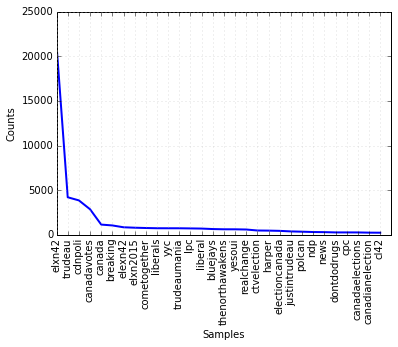

New file trudeau_graph_2015-10-20 20:53:28.805286.gexf saved to /Users/christopherallison/Documents/Coding/Gephi/twitter_stream.


In [8]:
twitter_data_to_graph(search_queries)

## You're done!  Now go check out your graph file in Gephi!